In [2]:
# pyright: reportUnusedCallResult=false
%matplotlib ipympl
# pyright: reportAny=false
import numpy as np
import pandas as pd
import glob

import neurokit2 as nk

from ecg_features import get_ecg_features
from eda_features import get_eda_features

dataset_path = "../../../experiment-data"
type FeatureDict = dict[str, np.ndarray]

In [8]:
def split_by_label(df: pd.DataFrame) -> list[tuple[str, pd.DataFrame]]:
    output: list[tuple[str, pd.DataFrame]] = []
    labels = ["Baseline", "AmusementClip", "StressClip", "EmoReset", "FormL", "FormM", "Debriefing"]
    start_idx = end_idx = 0
    for label in labels:
        if label == "FormL":
            if "FormLRead" in df["Event"].values:
                start_idx = df.index.get_loc(df[df["Event"] == "FormLRead"].index[0])
                end_idx = df.index.get_loc(df[df["Event"] == "L15"].index[-1])
            else:
                start_idx = df.index.get_loc(df[df["Event"] == "FormL"].index[0])
                end_idx = df.index.get_loc(df[df["Event"] == "FormL"].index[-1])
        elif label == "FormM":
            if "FormMRead" in df["Event"].values:
                start_idx = df.index.get_loc(df[df["Event"] == "FormMRead"].index[0])
                end_idx = df.index.get_loc(df[df["Event"] == "M15"].index[-1])
            else:
                start_idx = df.index.get_loc(df[df["Event"] == "FormM"].index[0])
                end_idx = df.index.get_loc(df[df["Event"] == "FormM"].index[-1])
        else:
            start_idx = df.index.get_loc(df[df["Event"] == label].index[0])
            end_idx = df.index.get_loc(df[df["Event"] == label].index[-1])
        output.append((label, df[start_idx:end_idx]))
    return output

In [4]:
data_file = f"{dataset_path}/20250710-18-UXFrustrationRecognition.Annotated.csv"
data_ecg: FeatureDict = dict()
data_eda: FeatureDict = dict()

data = pd.read_csv(
    data_file,
    delimiter=";",
    parse_dates=["Datetime", "Timestamp"],
    index_col=["Datetime",],
    dtype={
        "Timestamp": float,
        "Event": str,
        "ExtraEvent": str,
        "AccelLN_X": float,
        "AccelLN_Y": float,
        "AccelLN_Z": float,
        "Battery": float,
        "GSR_Range": int,
        "Skin_Conductance": float,
        "Skin_Resistance": float,
        "Gyro_X": float,
        "Gyro_Y": float,
        "Gyro_Z": float,
        "PPG": float,
        "Pressure": float,
        "Temperature": float,
        "AccelLN_X_Uncal": int,
        "AccelLN_Y_Uncal": int,
        "AccelLN_Z_Uncal": int,
        "Skin_Conductance_Uncal": int,
        "PPG_Uncal": int,}
    )
filename = data_file.split("/")[-1]
participant_id = filename.split("-")[1]

for label, event_df in split_by_label(data):
    sample_name = f"{participant_id}-{label}"
    file_ecg = np.array(event_df['PPG_Uncal'])
    file_eda = np.array(event_df['Skin_Conductance_Uncal'])

    data_ecg[sample_name] = (file_ecg - file_ecg.mean())/file_ecg.std()
    data_eda[sample_name] = (file_eda - file_eda.mean())/file_eda.std()

In [7]:
ecg_clean = data_ecg.copy()
eda_clean = data_eda.copy()

for ecg,eda in zip(data_ecg.items(), data_eda.items()):
    ecg_clean[ecg[0]] = nk.ecg_clean(ecg[1], sampling_rate=51.2, method="neurokit")
    eda_clean[eda[0]] = nk.eda_clean(eda[1], sampling_rate=51.2, method='neurokit')

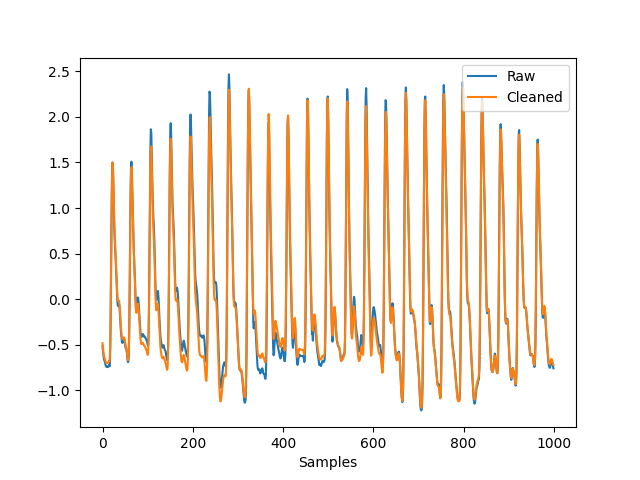

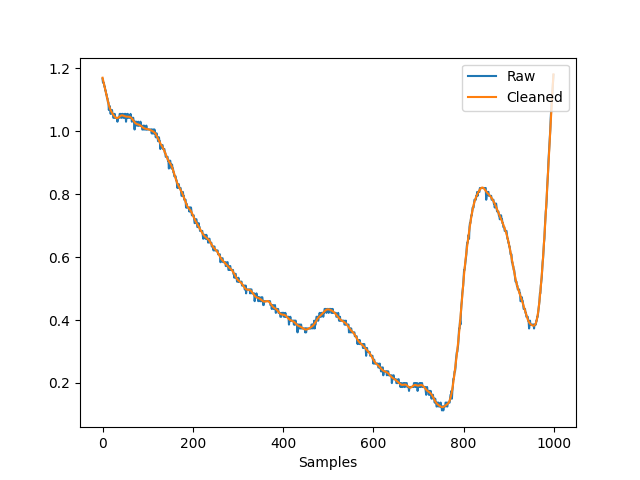

In [14]:
nk.signal_plot([data_ecg["18-FormM"][1000:2000], ecg_clean["18-FormM"][1000:2000]], labels=["Raw", "Cleaned"])
nk.signal_plot([data_eda["18-FormM"][1000:2000], eda_clean["18-FormM"][1000:2000]], labels=["Raw", "Cleaned"])